## Import libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Reading Data

In [3]:
os.chdir("F:\AI&DS\ML\CustomerSegmentProject\\")

retail = pd.read_excel("Online Retail.xlsx")

retail_df = retail.copy()

retail_df.info()

retail_df.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


## Data Cleaning and Exploration 

In [7]:
retail_df.isna().sum()

retail_df.dropna(inplace=True)

retail_df.shape

retail_df["Description"]

retail_df.groupby('Description').agg({"Quantity":"sum"}).sort_values("Quantity", ascending=False)

retail_df["InvoiceNo"].str.contains('C').count()

retail_df[~retail_df["InvoiceNo"].str.contains('C', na=False)]

retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']

retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## RFM Analysis

In [8]:
import datetime as dt

retail_df['InvoiceDate'].max()

today_date = dt.datetime(2011, 12, 11)

rfm = retail_df.groupby("CustomerID").agg({'InvoiceDate': lambda date: (today_date-date.max()).days,
                                           'InvoiceNo': lambda num: num.nunique(),
                                           'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ["Recency","Frequency","Monetary"]

rfm = rfm[rfm["Monetary"] > 0]

rfm["Recency_score"] = pd.qcut(rfm["Recency"],5,labels=[5,4,3,2,1])

rfm["Frequency_score"] = pd.qcut(rfm["Frequency"].rank(method='first'),5,labels=[1,2,3,4,5])

rfm["Monetary_score"] = pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])

rfm["RFM_score"] = (rfm["Recency_score"].astype(str) + rfm["Frequency_score"].astype(str))

seg_map = {
    
    r'[1-2][1-2]' : 'hibernating',
    r'[1-2][3-4]' : 'at_risk',
    r'[1-2]5' : 'cant_loose',
    r'3[1-2]' : 'about_to_sleep',
    r'33' : 'need_attention',
    r'[3-4][4-5]' : 'loyal_customers',
    r'41' : 'promising',
    r'51' : 'new_customers',
    r'[4-5][2-3]' : 'pot_loyal',
    r'5[4-5]' : 'champions'
    }

rfm['segment'] = rfm['RFM_score'].replace(seg_map, regex=True)

rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_score,segment
CustomerID,,,,,,,,
12347.0,3,7,4310.00,5,4,5,54,champions
12348.0,76,4,1797.24,2,3,4,23,at_risk
12349.0,19,1,1757.55,4,1,4,41,promising
12350.0,311,1,334.40,1,1,2,11,hibernating
12352.0,37,11,1545.41,3,5,4,35,loyal_customers


## 2D visualization of RFM Analysis

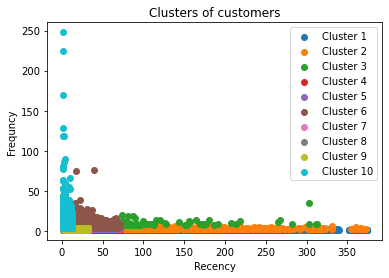

In [9]:
seg_list = list(seg_map.values())
for i in range(1,11):
    plt.scatter(rfm['Recency'][rfm['segment']==seg_list[i-1]] , rfm['Frequency'][rfm['segment']==seg_list[i-1]], label = 'Cluster '+str(i))
plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequncy')
plt.legend()
plt.show()

## K-means clustring

In [10]:
from sklearn.cluster import KMeans

X = rfm.iloc[:,[0,1]].values

## Elbow Method

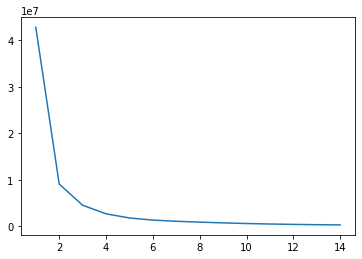

In [11]:
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X) ## it just fits the model and doesn't return the labels, you can access them using kmeans.labels_
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,15), wcss)

## Fitting the model and test

In [12]:
kmeans = KMeans(n_clusters=10, init="k-means++", random_state=42)
y_kmeans = kmeans.fit_predict(X)


y_test = kmeans.predict([[100,10]])
print("the cluster is ",y_test+1)

the cluster is  [10]


##  2D visualization of clustring


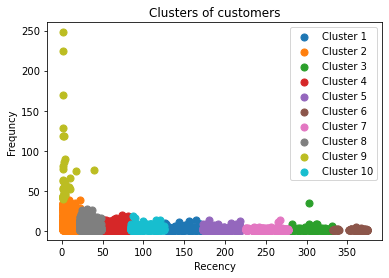

In [13]:
for i in range(1,11):
    plt.scatter(X[y_kmeans == i-1, 0], X[y_kmeans == i-1, 1], s = 50, label = 'Cluster '+str(i))
plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequncy')
plt.legend()
plt.show()